In [3]:
import time
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.primitives import Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler

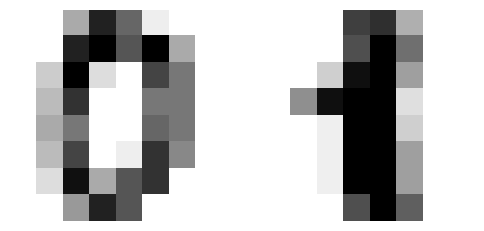

In [4]:
# Load the digits dataset
digits = load_digits(n_class=2)
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [5]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=22
)

# Reduce dimensions
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalize
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [8]:
map_zz = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)

# Define a sampler
sampler = StatevectorSampler()

# Use ComputeUncompute fidelity method
fidelity = ComputeUncompute(sampler=sampler)
quantum_kernel = FidelityQuantumKernel(feature_map=map_zz, fidelity=fidelity)

# Compute kernel matrix
start_time = time.time()  # Start timer
kernel_matrix = quantum_kernel.evaluate(sample_train)  # Run the function
kernel_test = quantum_kernel.evaluate(sample_test, sample_train)
end_time = time.time()  # End timer

execution_time = end_time - start_time  # Calculate time taken
print(f"Execution Time: {execution_time:.4f} seconds")

svm = SVC(kernel="precomputed")
svm.fit(kernel_matrix, label_train)

y_pred = svm.predict(kernel_test)
accuracy = accuracy_score(label_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")

Execution Time: 126.5668 seconds
Test Accuracy: 0.9000
